# Multi Layer Perceptron (MLP) with Jax

In [1]:
import copy
import jax
import jax.numpy as jnp
import optax
from flax import linen as nn
from flax.training.train_state import TrainState
from clu import parameter_overview
from IPython.display import Image, display
import numpy as np
import matplotlib.pyplot as plt
# declare colors for the plot
colors = {'orange': '#FF4B00', 'blue': '#005AFF', 'green': '#03AF7A'}
# check jax version, jax backend and computing devices
print("jax version: ", jax.__version__)
print("jax backend: ", jax.extend.backend.get_backend().platform)
print("jax devices: ", jax.devices())

jax version:  0.4.35
jax backend:  gpu
jax devices:  [CudaDevice(id=0)]


## Create Dataset

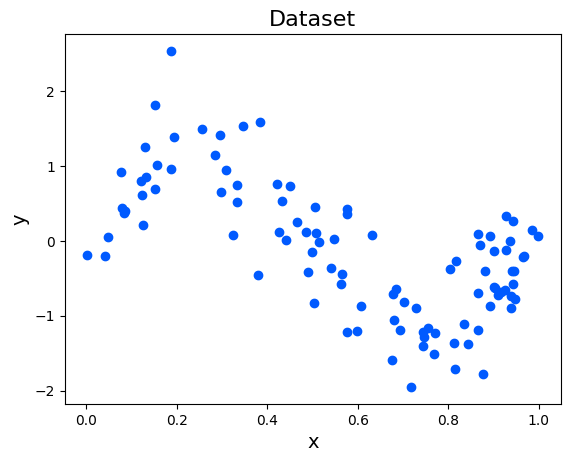

In [2]:
# create dataset
key = jax.random.key(0)
key, x_dataset_key = jax.random.split(key)
x_dataset = jax.random.uniform(x_dataset_key, (100, 1))
key, y_dataset_key = jax.random.split(key)
y_dataset = jnp.sin(2 * jnp.pi * x_dataset) + 0.5 * jax.random.normal(y_dataset_key, (100, 1))

# plot dataset
plt.title('Dataset', fontsize=16)
plt.scatter(x_dataset, y_dataset, color=colors['blue'])
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.show()

## Create Model (Multi-Layer Perceptron)

In [3]:
class Model(nn.Module):
    features: int
    @nn.compact
    def __call__(self, x):
        y = nn.Dense(features=self.features)(x)
        y = nn.sigmoid(y)
        y = nn.Dense(features=1)(y)
        return y

@jax.jit
def loss_fn(params, state, inputs, labels):
    prediction = state.apply_fn({'params': params}, inputs)
    loss = jnp.mean(optax.l2_loss(prediction, labels))
    return loss

@jax.jit
def train_step(state, inputs, labels):
    loss, grads = jax.value_and_grad(loss_fn)(state.params, state, inputs, labels)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss

## Train the Model

+----------------+---------+---------+------+---------+-------+
| Name           | Shape   | Dtype   | Size | Mean    | Std   |
+----------------+---------+---------+------+---------+-------+
| Dense_0/bias   | (10,)   | float32 | 10   | 0.0     | 0.0   |
| Dense_0/kernel | (1, 10) | float32 | 10   | 0.0202  | 0.935 |
| Dense_1/bias   | (1,)    | float32 | 1    | 0.0     | 0.0   |
| Dense_1/kernel | (10, 1) | float32 | 10   | -0.0407 | 0.167 |
+----------------+---------+---------+------+---------+-------+
Total: 31 -- 124 bytes
iteration:      0, loss: 0.4375
iteration:   1000, loss: 0.2255
iteration:   2000, loss: 0.2219
iteration:   3000, loss: 0.2149
iteration:   4000, loss: 0.2018
iteration:   5000, loss: 0.1802
iteration:   6000, loss: 0.1524
iteration:   7000, loss: 0.1327
iteration:   8000, loss: 0.1256
iteration:   9000, loss: 0.1237
iteration:   9999, loss: 0.1229


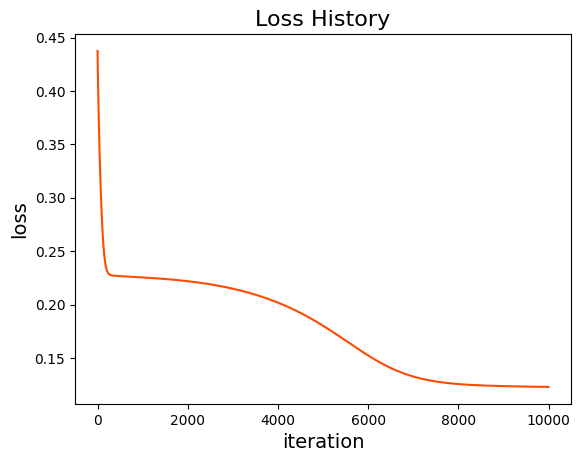

In [4]:
# parameters
learning_rate = 0.2 # learning rate
num_iter = 10000 # number of iterations

# create model and optimizer
model = Model(features=10)
key, model_init_key = jax.random.split(key)
params = model.init(model_init_key, x_dataset)['params']
tx = optax.sgd(learning_rate)
state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# visualize the model
print(parameter_overview.get_parameter_overview(state.params))

# do training for num_iter iterations
loss_history = []
for i in range(num_iter):
    # update weight parameters of the model
    new_state, loss = train_step(state, x_dataset, y_dataset)
    state = new_state

    # save loss history
    loss_history.append(jax.device_get(loss).tolist())

    # print loss every 1000 iterations
    if i % 1000 == 0:
        print(f'iteration: {i:6d}, loss: {jax.device_get(loss):.4f}')

# print loss of the last iteration
print(f'iteration: {i:6d}, loss: {jax.device_get(loss):.4f}')

# plot loss history
plt.title('Loss History', fontsize=16)
plt.plot(loss_history, color=colors['orange'])
plt.xlabel('iteration', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.show()

## Plot the Prediction

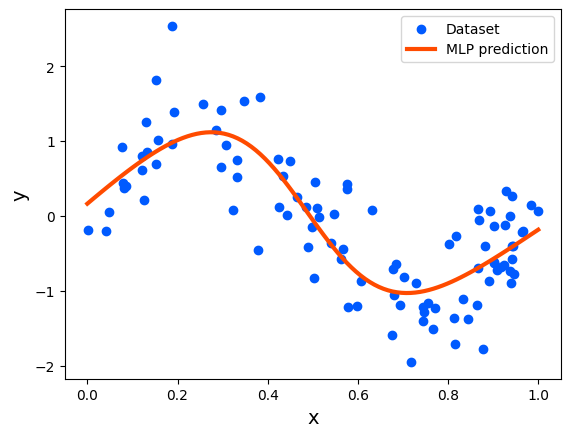

In [5]:
# plot dataset
plt.scatter(x_dataset, y_dataset, color=colors['blue'], label='Dataset')

# plot prediction of the trained model
x_tensor = jnp.linspace(0, 1, 100).reshape(-1, 1)
y_tensor = model.apply({'params': state.params}, x_tensor)
plt.plot(x_tensor, y_tensor, color=colors['orange'], linewidth=3, label='MLP prediction')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend()
# plt.savefig('mlp.png', dpi=300) # save figure
plt.show()